<a href="https://colab.research.google.com/github/hazerr/mlzoomcamp/blob/main/homework6_mlzoomcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

In [2]:
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv(data)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df = df[df['ocean_proximity'].isin(['INLAND', '<1H OCEAN'])]

In [5]:
df.ocean_proximity.value_counts()

<1H OCEAN    9136
INLAND       6551
Name: ocean_proximity, dtype: int64

In [6]:
df.fillna(0, inplace=True)

In [7]:
df.median_house_value = np.log1p(df.median_house_value)

In [8]:
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [11]:
 train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

Question 1

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Question 2

In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

In [16]:
print(round(rmse,3))

0.245


Question 3

In [17]:
scores= []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    scores.append((n, rmse))

In [18]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores.head()

,n_estimators,rmse
0,10,0.244911
1,20,0.238384
2,30,0.236135
3,40,0.234671
4,50,0.234439


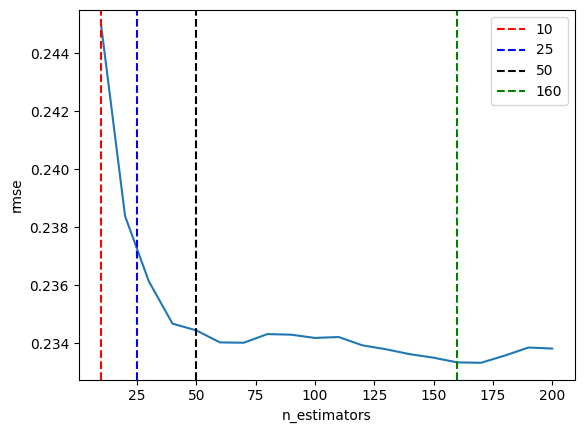

In [19]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.axvline(10, linestyle= '--', color='r', label=10)
plt.axvline(25, linestyle= '--', color='b', label=25)
plt.axvline(50, linestyle= '--', color='k', label=50)
plt.axvline(160, linestyle= '--', color='g', label=160)

plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.legend()
plt.show()

In [ ]:
Question 4

In [ ]:
scores = []

for d in [10,15,20,25]:
    for n in range(10,201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val,y_pred)
        rmse = np.sqrt(mse)

        scores.append((d,n,rmse))

In [ ]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators','max_depth', 'rmse'])
df_scores.head()

In [ ]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label = 'max_depth = %d' % d)

plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.legend()
plt.show()

Question 5

In [ ]:
new_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
new_model.fit(X_train, y_train)

In [ ]:
new_model.feature_importances_

In [ ]:
dv.feature_names_

In [ ]:
idx_max = np.argmax(new_model.feature_importances_)

In [ ]:
dv.get_feature_names_out()[idx_max]

Question 6

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train )
dval = xgb.DMatrix(X_val, label=y_val)

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
xgb.train(xgb_params, dtrain, num_boost_round = 100 , evals= watchlist )

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))


    columns = ['num_iter','train_rmse','val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results



In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [ ]:
etas = ['eta=0.1', 'eta=0.3']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_rmse, label = eta)

plt.xlabel('num_iter')
plt.ylabel('rmse')
plt.legend()
plt.show()